In [22]:
import pandas as pd
import psycopg2
import dotenv
import os

dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

conn = psycopg2.connect(
    host=PG_HOST,
    database=PG_DATABASE,
    user=PG_USER,
    password=PG_PASSWORD,
    port=PG_PORT,
    sslmode="require",
)

query = """
SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
JOIN teams t ON p.team_id = t.team_id
WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
"""
tracking_df = pd.read_sql_query(query, conn)
tracking_df.head()

,frame_id,timestamp,player_id,x,y,jersey_number,player_name,team_id
0,1722799204000,00:05:04,pi2sxs616a52jvpfywgwjowl,46.591803,82.008591,22,G. Ruyssen,4dtif7outbuivua8umbwegoo5
1,1722799204000,00:05:04,60gs7lod7de72ypcs6qfup8q2,53.204590,50.845902,9,A. Guðjohnsen,8y3iucyxguipljcmf87a11bk9
2,1722799204000,00:05:04,3r04y1fejoh9e8qbge3exy3u1,21.321672,2.013952,22,N. Fadiga,8y3iucyxguipljcmf87a11bk9
3,1722799204000,00:05:04,dxcsuw39xzusjsj5e1jw53y6t,77.095147,49.095082,34,M. Verrips,4dtif7outbuivua8umbwegoo5
4,1722799204000,00:05:04,863wevd1kdzq5sd7qpmhr4lqs,30.326181,13.390267,88,F. Ferraro,4dtif7outbuivua8umbwegoo5


In [23]:
def execute_query(query):
    return pd.read_sql_query(query, conn)

In [24]:
possession_df = execute_query("""
WITH action_changes AS (
    SELECT
        a.*,
        LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
        LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM
        spadl_actions a
    WHERE
        a.game_id = '5uts2s7fl98clqz8uymaazehg'
),

possession_markers AS (
    SELECT
        *,
        CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM
        action_changes
),

possession_sequences AS (
    SELECT
        *,
        SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM
        possession_markers
),

possession_stats AS (
    SELECT
        possession_group,
        team_id,
        COUNT(*) AS action_count,
        MAX(id) AS last_action_id
    FROM
        possession_sequences
    GROUP BY
        possession_group, team_id
)

-- Find possession-ending actions
SELECT
    a.id AS action_id,
    a.game_id,
    a.period_id,
    a.seconds AS time_seconds,
    p.player_name,
    t.team_name AS team_losing_possession,
    nt.team_name AS team_gaining_possession,
    a.action_type AS type_name,
    a.result AS result_name,
    ps.action_count AS consecutive_team_actions,
    a.start_x,
    a.start_y,
    a.end_x,
    a.end_y,
    a.id AS original_event_id
FROM
    possession_sequences a
JOIN
    possession_stats ps ON a.possession_group = ps.possession_group 
                                            AND a.team_id = ps.team_id
                                            AND a.id = ps.last_action_id  
JOIN
    players p ON a.player_id = p.player_id
JOIN
    teams t ON a.team_id = t.team_id
LEFT JOIN
    teams nt ON a.next_team_id = nt.team_id
WHERE
    a.team_id != a.next_team_id  
    AND a.next_team_id IS NOT NULL  
ORDER BY
    a.period_id,
    a.seconds,
    a.id;
""")

for period_id in possession_df["period_id"].unique():
    print(f"Period {period_id}")
    average_ttrs: dict[str, float] = {}
    average_ttr_count: dict[str, int] = {}
    last_posession: dict[str, float] = {}
    for _, posession in possession_df[possession_df["period_id"] == period_id].iterrows():
        team_losing_possession = posession["team_losing_possession"]
        team_gaining_possession = posession["team_gaining_possession"]
        seconds = posession["time_seconds"]
        last_posession[team_gaining_possession] = seconds
        if team_losing_possession in last_posession:
            average_ttrs[team_gaining_possession] = average_ttrs.get(team_gaining_possession, 0) + (seconds - last_posession[team_losing_possession])
            average_ttr_count[team_gaining_possession] = average_ttr_count.get(team_gaining_possession, 0) + 1
        else:
            print(f"{team_gaining_possession} got the first possession at {seconds} seconds")

    for team, ttr in average_ttrs.items():
        average_ttrs[team] = ttr / average_ttr_count[team]
        print(f"Average TTR for {team}: {average_ttrs[team]} seconds")

Period 1
Dender got the first possession at 22.0 seconds
Average TTR for Gent: 10.25 seconds
Average TTR for Dender: 18.072916666666668 seconds
Period 2
Gent got the first possession at 5.0 seconds
Average TTR for Dender: 16.387931034482758 seconds
Average TTR for Gent: 10.513043478260869 seconds


In [25]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_tracking_data(tracking_data):
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
                  pitch_length=105, pitch_width=68)  # Adjust dimensions if necessary
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Extract timestamp and team names
    timestamp = tracking_data['timestamp'].iloc[0]
    team_names = tracking_data['team_id'].unique()
    colors = mpl.colors.TABLEAU_COLORS
    color_map = {team: color for team, color in zip(team_names, colors.values())}
    
    # Plot player positions
    for _, row in tracking_data.iterrows():
        x = row['x']
        y = row['y']
        player_name = row['player_name']
        team_name = row['team_id']
        jersey_no = row['jersey_number']
        
        # Plot the ball
        if row['player_name'] == 'Ball':
            pitch.scatter(x, y, s=90, color='yellow', ax=ax, label='Ball')
        else:
            # Plot players
            pitch.scatter(x, y, s=100, color=color_map[team_name], ax=ax, label=team_name)
        
        # Add player names (excluding the ball)
        if row['player_name'] != 'Ball':
            ax.text(x + 2, y + 2, f"{player_name} ({jersey_no})", fontsize=8)
    
    # Set title
    ax.set_title(f'Player Positions at Event Timestamp: {timestamp}', fontsize=16)
    plt.tight_layout()
    plt.show()

query = """
SELECT pt.frame_id, pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
JOIN teams t ON p.team_id = t.team_id
WHERE pt.game_id = '5uts2s7fl98clqz8uymaazehg';
"""
tracking_df = execute_query(query)
frame_id = tracking_df['frame_id'].unique()[0]  
filtered_tracking_df = tracking_df[tracking_df['frame_id'] == frame_id]


In [26]:
match_id = "5uts2s7fl98clqz8uymaazehg"

possession_df = pd.read_sql_query(
    f"""
WITH action_changes AS (
    SELECT  a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
            LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM spadl_actions a
    WHERE a.game_id = '{match_id}'
),
possession_markers AS (
    SELECT  *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM action_changes
),
possession_sequences AS (
    SELECT  *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM possession_markers
)
SELECT  a.*,
        t.team_id AS team_losing_possession,
        nt.team_id AS team_gaining_possession
FROM possession_sequences a
JOIN teams t ON a.team_id = t.team_id
LEFT JOIN teams nt ON a.next_team_id = nt.team_id
WHERE a.team_id != a.next_team_id AND a.next_team_id IS NOT NULL  
ORDER BY a.period_id, a.seconds, a.id;
""",
    conn,
)

spadl_actions = pd.read_sql_query(
    f"SELECT * FROM spadl_actions WHERE game_id = '{match_id}'", conn
)

home_team = (
    pd.read_sql_query(
        f"SELECT home_team_id FROM matches WHERE match_id = '{match_id}'", conn
    )
    .squeeze()
)

for period_id in possession_df["period_id"].unique():
    average_ttr = {}
    average_ttr_count = {}
    last_possession = {}
    for _, possession in possession_df[
        possession_df["period_id"] == period_id
    ].iterrows():
        team_losing = possession["team_losing_possession"]
        team_gaining = possession["team_gaining_possession"]
        cur_seconds = possession["seconds"]
        last_possession[team_gaining] = cur_seconds
        if team_losing in last_possession:
            average_ttr[team_gaining] = average_ttr.get(team_gaining, 0) + (
                cur_seconds - last_possession[team_losing]
            )
            average_ttr_count[team_gaining] = average_ttr_count.get(team_gaining, 0) + 1

            avg_ttr = average_ttr[team_gaining] / average_ttr_count[team_gaining]
            possessing_team = "home" if team_gaining == home_team else "other"

            spadl_actions.loc[
                spadl_actions["id"] == possession["id"],
                ["possessing_team", f"avg_ttr_{possessing_team}"],
            ] = [possessing_team, avg_ttr]

spadl_actions[["avg_ttr_home", "avg_ttr_other", "possessing_team"]] = spadl_actions[
    ["avg_ttr_home", "avg_ttr_other", "possessing_team"]
].ffill()
spadl_actions

,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,action_type,result,bodypart,possessing_team,avg_ttr_home,avg_ttr_other
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,60gs7lod7de72ypcs6qfup8q2,8y3iucyxguipljcmf87a11bk9,52.500,34.000,43.365,36.312,0,1,0,NaN,NaN,NaN
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,43.365,36.312,48.720,34.680,21,1,0,NaN,NaN,NaN
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,48.720,34.680,45.150,50.184,0,1,0,NaN,NaN,NaN
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8fs5klbsyx06c5ds9s1i3xu96,8y3iucyxguipljcmf87a11bk9,46.200,48.008,39.270,63.376,0,1,0,NaN,NaN,NaN
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,39.270,63.376,42.945,63.920,21,1,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,27208,5uts2s7fl98clqz8uymaazehg,2,3104.0,3are60mt98ibeazgcyjvuy7tg,4dtif7outbuivua8umbwegoo5,33.810,29.512,32.130,58.480,0,1,0,other,10.500000,16.478261
2075,27209,5uts2s7fl98clqz8uymaazehg,2,3106.5,2961iy0sg9zmy0r6fzbr2dmg9,4dtif7outbuivua8umbwegoo5,32.130,58.480,32.865,63.988,21,1,0,other,10.500000,16.478261
2076,27210,5uts2s7fl98clqz8uymaazehg,2,3109.0,2961iy0sg9zmy0r6fzbr2dmg9,4dtif7outbuivua8umbwegoo5,32.865,63.988,5.040,59.636,0,1,0,home,10.513043,16.478261
2077,27211,5uts2s7fl98clqz8uymaazehg,2,3115.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,4.200,67.116,4.200,67.116,9,0,0,other,10.513043,16.387931


In [27]:
import numpy as np

match_id = "5uts2s7fl98clqz8uymaazehg"

possession_df = pd.read_sql_query(
    f"""
WITH action_changes AS (
    SELECT  a.*,
            LAG(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS prev_team_id,
            LEAD(a.team_id) OVER (ORDER BY a.period_id, a.seconds, a.id) AS next_team_id
    FROM spadl_actions a
    WHERE a.game_id = '{match_id}'
),
possession_markers AS (
    SELECT  *,
            CASE WHEN prev_team_id IS NULL OR team_id != prev_team_id THEN 1 ELSE 0 END AS is_new_possession
    FROM action_changes
),
possession_sequences AS (
    SELECT  *,
            SUM(is_new_possession) OVER (ORDER BY period_id, seconds, id) AS possession_group
    FROM possession_markers
)
SELECT  a.*,
        t.team_id AS team_losing_possession,
        nt.team_id AS team_gaining_possession
FROM possession_sequences a
JOIN teams t ON a.team_id = t.team_id
LEFT JOIN teams nt ON a.next_team_id = nt.team_id
WHERE a.team_id != a.next_team_id AND a.next_team_id IS NOT NULL  
ORDER BY a.period_id, a.seconds, a.id;
""",
    conn,
)

spadl_actions = pd.read_sql_query(
    f"SELECT * FROM spadl_actions WHERE game_id = '{match_id}'", conn
)

home_team = pd.read_sql_query(
    f"SELECT home_team_id FROM matches WHERE match_id = '{match_id}'", conn
).squeeze()

spadl_actions[["mavg_ttr_home", "mavg_ttr_other", "last_ttr_home", "last_ttr_other"]] = np.nan
spadl_actions["possessing_team"] = None

for period_id in possession_df["period_id"].unique():
    last_possession = {}
    for _, possession in possession_df[
        possession_df["period_id"] == period_id
    ].iterrows():
        team_losing = possession["team_losing_possession"]
        team_gaining = possession["team_gaining_possession"]
        last_possession[team_gaining] = possession["seconds"]
        if team_losing in last_possession:
            possessing_team = "home" if team_gaining == home_team else "other"
            last_ttr = last_possession[team_gaining] - last_possession[team_losing]

            mavg_ttr = (
                spadl_actions[f"last_ttr_{possessing_team}"]
                .dropna()
                .rolling(5)
                .mean()
            )

            if len(mavg_ttr) == 0:
                mavg_ttr = 0
            else:
                mavg_ttr = mavg_ttr.iloc[-1]

            spadl_actions.loc[
                spadl_actions["id"] == possession["id"],
                [
                    "possessing_team",
                    f"last_ttr_{possessing_team}",
                    f"mavg_ttr_{possessing_team}",
                ],
            ] = [possessing_team, last_ttr, mavg_ttr]

residual_columns = ["last_ttr_home", "last_ttr_other", "mavg_ttr_home", "mavg_ttr_other", "possessing_team"]
spadl_actions[residual_columns] = spadl_actions[residual_columns].ffill()
spadl_actions

,id,game_id,period_id,seconds,player_id,team_id,start_x,start_y,end_x,end_y,action_type,result,bodypart,mavg_ttr_home,mavg_ttr_other,last_ttr_home,last_ttr_other,possessing_team
0,25134,5uts2s7fl98clqz8uymaazehg,1,0.0,60gs7lod7de72ypcs6qfup8q2,8y3iucyxguipljcmf87a11bk9,52.500,34.000,43.365,36.312,0,1,0,NaN,NaN,NaN,NaN,None
1,25135,5uts2s7fl98clqz8uymaazehg,1,0.5,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,43.365,36.312,48.720,34.680,21,1,0,NaN,NaN,NaN,NaN,None
2,25136,5uts2s7fl98clqz8uymaazehg,1,1.0,18pgjfpl9s8qy32mblzygsyc5,8y3iucyxguipljcmf87a11bk9,48.720,34.680,45.150,50.184,0,1,0,NaN,NaN,NaN,NaN,None
3,25137,5uts2s7fl98clqz8uymaazehg,1,4.0,8fs5klbsyx06c5ds9s1i3xu96,8y3iucyxguipljcmf87a11bk9,46.200,48.008,39.270,63.376,0,1,0,NaN,NaN,NaN,NaN,None
4,25138,5uts2s7fl98clqz8uymaazehg,1,5.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,39.270,63.376,42.945,63.920,21,1,0,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,27208,5uts2s7fl98clqz8uymaazehg,2,3104.0,3are60mt98ibeazgcyjvuy7tg,4dtif7outbuivua8umbwegoo5,33.810,29.512,32.130,58.480,0,1,0,13.0,7.4,17.0,0.0,other
2075,27209,5uts2s7fl98clqz8uymaazehg,2,3106.5,2961iy0sg9zmy0r6fzbr2dmg9,4dtif7outbuivua8umbwegoo5,32.130,58.480,32.865,63.988,21,1,0,13.0,7.4,17.0,0.0,other
2076,27210,5uts2s7fl98clqz8uymaazehg,2,3109.0,2961iy0sg9zmy0r6fzbr2dmg9,4dtif7outbuivua8umbwegoo5,32.865,63.988,5.040,59.636,0,1,0,15.8,7.4,12.0,0.0,home
2077,27211,5uts2s7fl98clqz8uymaazehg,2,3115.0,8kz0e83d3azssd7unbk2lqt0q,8y3iucyxguipljcmf87a11bk9,4.200,67.116,4.200,67.116,9,0,0,15.8,7.0,12.0,6.0,other


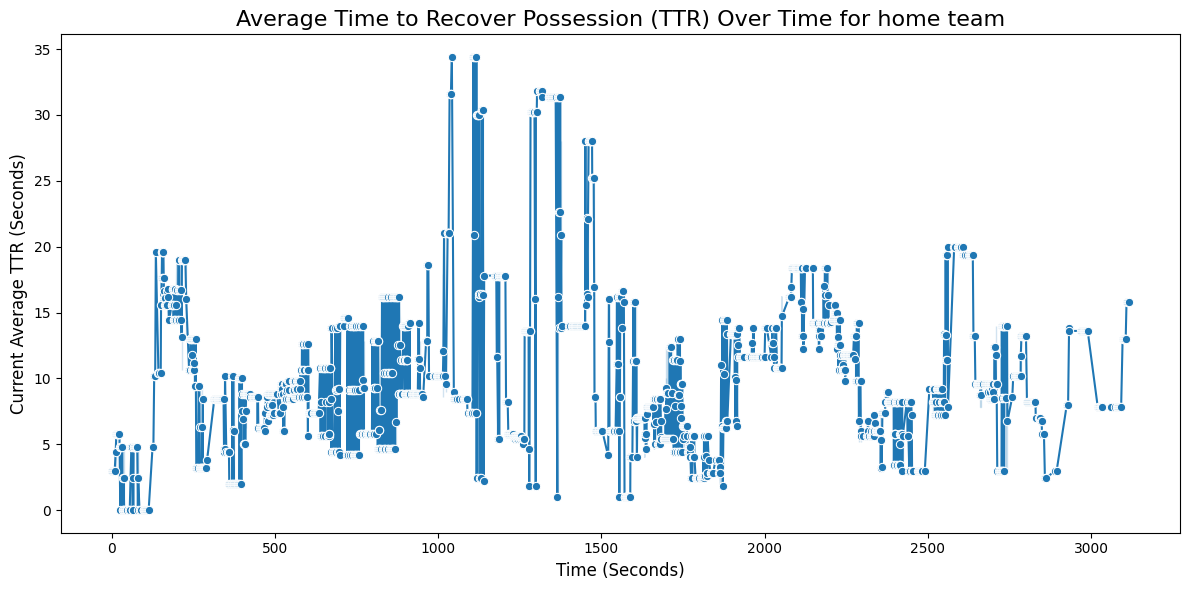

In [28]:
import seaborn as sns

ttr_data = spadl_actions[spadl_actions["mavg_ttr_home"].notna()]

plt.figure(figsize=(12, 6))
sns.lineplot(data=ttr_data, x="seconds", y="mavg_ttr_home", marker="o")
plt.title("Average Time to Recover Possession (TTR) Over Time for home team", fontsize=16)
plt.xlabel("Time (Seconds)", fontsize=12)
plt.ylabel("Current Average TTR (Seconds)", fontsize=12)
# plt.legend(title="Team Name")
plt.tight_layout()
plt.show()

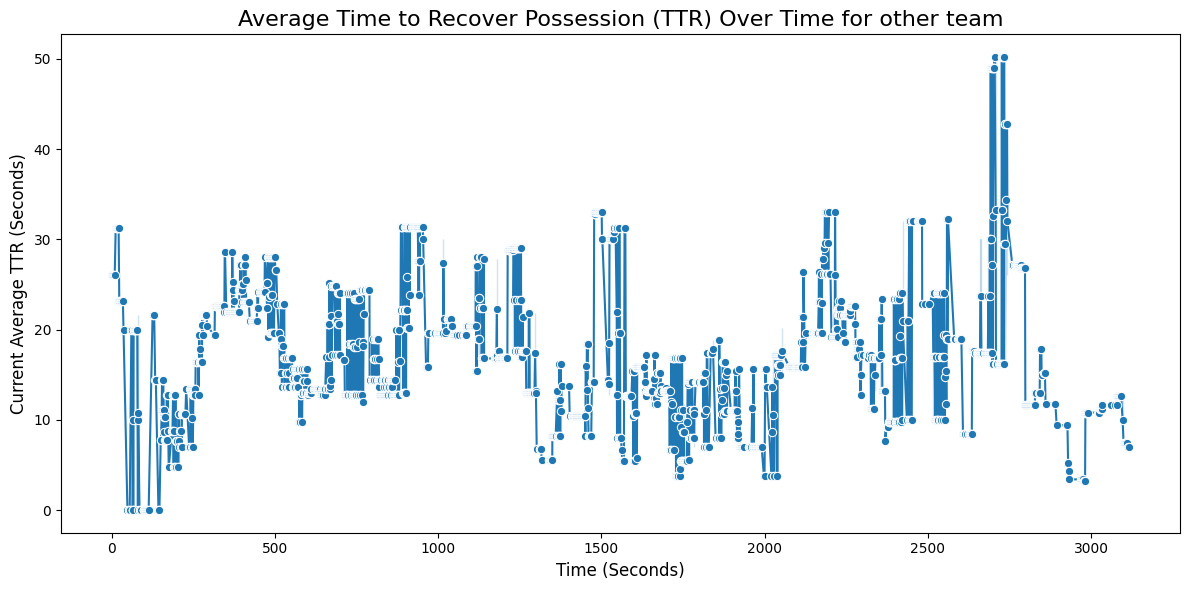

In [29]:
ttr_data = spadl_actions[spadl_actions["mavg_ttr_other"].notna()]

plt.figure(figsize=(12, 6))
sns.lineplot(data=ttr_data, x="seconds", y="mavg_ttr_other", marker="o")
plt.title("Average Time to Recover Possession (TTR) Over Time for other team", fontsize=16)
plt.xlabel("Time (Seconds)", fontsize=12)
plt.ylabel("Current Average TTR (Seconds)", fontsize=12)
# plt.legend(title="Team Name")
plt.tight_layout()
plt.show()

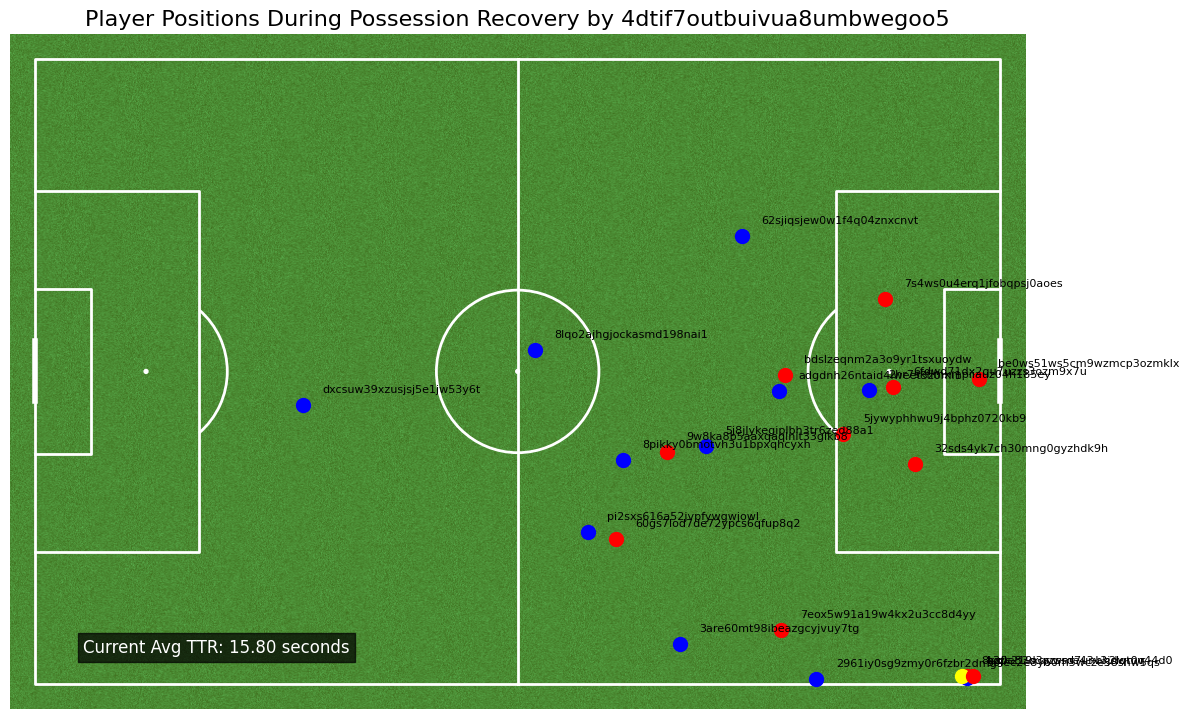

In [30]:
from datetime import datetime, timedelta

# Function to normalize the timestamp column
def normalize_timestamp(value):
    try:
        # Handle timedelta-like strings (e.g., "0 days 00:00:00")
        if "days" in str(value):
            # Convert to seconds and then to a datetime object
            seconds = pd.to_timedelta(value).total_seconds()
            return datetime(1900, 1, 1) + timedelta(seconds=seconds)
        else:
            # Handle time strings (e.g., "00:51:57.280000")
            return datetime.strptime(value, "%H:%M:%S.%f")
    except Exception as e:
        return None

# Normalize the 'timestamp' column
tracking_df["timestamp"] = tracking_df["timestamp"].apply(normalize_timestamp)

# Get the last possession event
possession_event = possession_df.iloc[-1]
recovery_time = possession_event["seconds"]  # Recovery time in seconds
team_gaining = possession_event["team_gaining_possession"]

# Parse match start time (assuming match starts at "00:00:00")
match_start_time = datetime(1900, 1, 1, 0, 0, 0)

# Add recovery time to match start time
recovery_time_dt = match_start_time + timedelta(seconds=recovery_time)

# Filter tracking data with a tolerance for timestamp matching
tolerance = timedelta(milliseconds=500)  # 500ms tolerance
recovery_tracking_data = tracking_df[
    (tracking_df["timestamp"] >= recovery_time_dt - tolerance) &
    (tracking_df["timestamp"] <= recovery_time_dt + tolerance)
]

# Filter spadl_actions for the team gaining possession
filtered_spadl_actions = spadl_actions[spadl_actions["team_id"] == team_gaining]

# Get the current average TTR for the team gaining possession
if not filtered_spadl_actions.empty:
    current_avg_ttr = filtered_spadl_actions["mavg_ttr_home"].iloc[-1]
else:
    current_avg_ttr = None

# Plot the recovery event
def plot_recovery_with_ttr(tracking_data, recovery_player_id, team_gaining, current_avg_ttr):
    pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
                  pitch_length=105, pitch_width=68)
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Plot player positions
    for _, row in tracking_data.iterrows():
        x, y = row['x'], row['y']
        player_id = row['player_id']
        team_name = row['team_id']
        color = 'yellow' if row['player_id'] == recovery_player_id else 'blue' if team_name == team_gaining else 'red'
        
        # Plot players
        pitch.scatter(x, y, s=100, color=color, ax=ax, label=team_name if row['player_id'] != recovery_player_id else "Recovered Ball")
        ax.text(x + 2, y + 2, f"{player_id}", fontsize=8)
    
    # Annotate TTR
    if current_avg_ttr is not None:
        ax.text(5, 5, f"Current Avg TTR: {current_avg_ttr:.2f} seconds", fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.7))
    else:
        ax.text(5, 5, "Current Avg TTR: N/A", fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.7))
    
    # Set title
    ax.set_title(f'Player Positions During Possession Recovery by {team_gaining}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
plot_recovery_with_ttr(recovery_tracking_data, possession_event["player_id"], team_gaining, current_avg_ttr)

In [31]:
# from matplotlib.patches import Ellipse
# import matplotlib.pyplot as plt
# import matplotlib.patheffects as path_effects
# from datetime import datetime, timedelta
# from scipy.spatial import Voronoi, voronoi_plot_2d
# import numpy as np

# # Constants for pitch dimensions
# X_SIZE = 105  # Pitch length in meters
# Y_SIZE = 68   # Pitch width in meters

# def draw_pitch():
#     """Draws a soccer pitch."""
#     fig, ax = plt.subplots(figsize=(10, 7))
#     pitch = Pitch(pitch_color='grass', line_color='white', pitch_type='opta',
#                   pitch_length=X_SIZE, pitch_width=Y_SIZE)
#     pitch.draw(ax=ax)
#     return fig, ax

# def draw_frame_with_voronoi(tracking_df, players_df, t, text_color='black', tolerance_ms=500):
#     """
#     Draws a single frame of player and ball positions on the pitch with a Voronoi diagram.

#     Parameters:
#     - tracking_df: DataFrame containing tracking data (x, y, player_id, team_id, etc.).
#     - players_df: DataFrame containing player metadata (e.g., team, jersey number, colors).
#     - t: Timestamp (string or datetime) for the frame to draw.
#     - text_color: Color of the text for player numbers.
#     - tolerance_ms: Tolerance in milliseconds for matching timestamps.
#     """
#     # Normalize the timestamp column in tracking_df
#     tracking_df["timestamp"] = pd.to_datetime(tracking_df["timestamp"])

#     # Convert t to a datetime object
#     if isinstance(t, str):
#         t = datetime.strptime(t, "%H:%M:%S.%f")

#     # Filter tracking data for the given time with tolerance
#     tolerance = timedelta(milliseconds=tolerance_ms)
#     frame_data = tracking_df[
#         (tracking_df['timestamp'] >= t - tolerance) & 
#         (tracking_df['timestamp'] <= t + tolerance)
#     ]
#     if frame_data.empty:
#         print(f"No data available for timestamp {t}")
#         return None, None, None

#     # Add default colors if 'edgecolor' or 'bgcolor' columns are missing
#     if 'edgecolor' not in players_df.columns:
#         players_df['edgecolor'] = players_df['team_id'].apply(
#             lambda team: 'blue' if team == 'home' else 'red'
#         )
#     if 'bgcolor' not in players_df.columns:
#         players_df['bgcolor'] = players_df['team_id'].apply(
#             lambda team: 'lightblue' if team == 'home' else 'pink'
#         )

#     # Draw the pitch
#     fig, ax = draw_pitch()

#     # Extract player positions and team information
#     player_positions = []
#     team_colors = []
#     for _, row in frame_data.iterrows():
#         player_id = row['player_id']
#         x, y = row['x'], row['y']

#         if player_id != 0:  # Exclude the ball
#             player_positions.append([x, y])
#             player_info = players_df.loc[players_df['player_id'] == player_id]
#             if not player_info.empty:
#                 team_colors.append(player_info.iloc[0]['bgcolor'])

#     # Compute Voronoi diagram
#     if len(player_positions) > 2:  # Voronoi requires at least 3 points
#         vor = Voronoi(player_positions)
#         for region_idx, region in enumerate(vor.regions):
#             if not -1 in region and len(region) > 0:  # Ignore infinite regions
#                 polygon = [vor.vertices[i] for i in region]
#                 color = team_colors[region_idx] if region_idx < len(team_colors) else 'gray'
#                 ax.fill(*zip(*polygon), color=color, alpha=0.3)

#     # Draw players and ball
#     for _, row in frame_data.iterrows():
#         player_id = row['player_id']
#         x, y = row['x'], row['y']

#         if player_id == 0:  # Ball
#             size = 1.3
#             lw = 0.7
#             color = 'black'
#             edge = 'white'
#             zorder = 100
#         else:  # Players
#             size = 3
#             lw = 2
#             player_info = players_df.loc[players_df['player_id'] == player_id]

#             # Check if player_info is empty
#             if player_info.empty:
#                 print(f"Warning: player_id {player_id} not found in players_df.")
#                 continue

#             player_info = player_info.iloc[0]
#             edge = player_info['edgecolor']
#             color = player_info['bgcolor']
#             zorder = 21 if player_info['team_id'] == 'attack' else 20

#         # Draw the player or ball
#         ax.add_artist(Ellipse((x, y),
#                               size / X_SIZE * 100, size / Y_SIZE * 100,
#                               edgecolor=edge,
#                               linewidth=lw,
#                               facecolor=color,
#                               alpha=0.8,
#                               zorder=zorder))

#         # Add player numbers
#         if player_id != 0:
#             jersey_number = player_info['player_id']
#             if not pd.isnull(jersey_number):
#                 if isinstance(jersey_number, float):
#                     jersey_number = int(jersey_number)
#                 text = plt.text(x, y, str(jersey_number),
#                                 horizontalalignment='center', verticalalignment='center',
#                                 fontsize=8, color=text_color, zorder=22, alpha=0.8)
#                 text.set_path_effects([path_effects.Stroke(linewidth=1, foreground=text_color, alpha=0.8),
#                                        path_effects.Normal()])

#     return fig, ax, frame_data

# player_query = """
# SELECT DISTINCT(p.*)
# FROM players p
# INNER JOIN matchevents m ON p.team_id = m.team_id
# WHERE m.match_id = '5uts2s7fl98clqz8uymaazehg' OR p.player_id = 'ball';
# """

# players_df = execute_query(player_query)
# # Example usage
# t = "00:51:57.280000" # Time in seconds
# draw_frame_with_voronoi(tracking_df, players_df, t)